In [1]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import numpy as np; np.set_printoptions(linewidth=110);
import glob
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import hierarchical_model_generator
import hierarchical_sampling_model

In [2]:
import pandas as pd
print('pd', pd.__version__)
import allensdk
print('allensdk', allensdk.__version__)
import h5py
print('h5py', h5py.__version__)
import pynwb
print('pynwb', pynwb.__version__)
import hdmf
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Hierarchical model Generator

### Load tamplate model

In [3]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch5_20201111-121627_generator_template.pkl', # B A3
'798911424_checkpoints_batch14_20201023-042306_generator_template.pkl']  # BSS A3

In [4]:

def runner(random_seed):
# random_seed = 0

    print(f'---------------------- {random_seed} --------------------')
    ## Load simulation
    generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
    data_folder = project_dir + 'Output/simulation/'
    file_path = (data_folder + model_files[4])
    generator_model.load_model(file_path)

    np.random.seed(random_seed)  # Random seed for pseudo data.
    model_feature_type = 'BSS'
    generator_model.initial_step(model_feature_type=model_feature_type, num_trials=180, num_conditions = 1)

    ## Generate data
    select_clist = [4]
    generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
    generator_model.generate_q()
    generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
    generator_model.generate_z(verbose=False)
    generator_model.generate_p_gac(verbose=False)
    generator_model.generate_log_lambda_nargc(verbose=False)
    generator_model.generate_spikes(verbose=False)

    ## Prepare for the data fitting.
    trial_time_window=generator_model.trial_time_window
    spike_train_time_line = generator_model.spike_train_time_line
    spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
    session = None
    spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
    units_probes = generator_model.selected_units['probe_description']
    probes = generator_model.probes
    selected_units = generator_model.selected_units
    trials_indices = generator_model.trials_indices
    trials_groups = generator_model.trials_groups

    ## Initial HBM
    np.random.seed(0)  # Random seed for MCMC chain.
    model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
    model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                       trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3, 
                       model_feature_type='BSS', prior_type='diag',
                       eta_smooth_tuning=3e-8, verbose=False)
    # Initialize with true values.
    model.set_model(generator_model, select_clist=select_clist)

    ##
    clist = [0]
    thin_begin = 0
    thin_step = 1

    t = trange(0, 2000)
    for itr in t:
        slc = (itr >= thin_begin) and (itr % thin_step == 0)
        for c in clist:
            if itr > 400:
                model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
                model.update_f_cross_pop_ca(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
            # proposal_scalar=0.1 BA2  0.04 BSS A3
            model.update_q_arc(c, sample_type='sample', proposal_scalar=0.02, fit_peak_ratio=0,
                               record=(c==clist[-1] and slc), verbose=False)
            if itr > 200 and itr % 20 == 0:
                model.update_z_ngac(c, sample_type='sample',
                                    record=(c==clist[-1]), verbose=False)
            if itr > 200:
                model.update_p_gac(c, sample_type='sample',
                                   record=(c==clist[-1] and slc), verbose=False)
        if itr > 200:
            model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
        model.complete_log_likelihood(clist)
        t.set_description(f'{model.samples.log_likelihood[-1]:.2f} | {model.samples.q_accept_ratio_mean:.3f}')

    ## KS test
    z_c = model.samples.get_z_mode(burn_in=0, end=None, step=1, sub_group_df_c=model.sub_group_df_c)
    lambda_garc = model.samples.get_lambda_garc(clist, spike_train_time_line, model_feature_type=model.model_feature_type,
            burn_in=600, end=None, step=1, samples_aligned='end', verbose=False)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.05, null_type='sampling', num_null_samples=1000, correction=None)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.001, null_type='sampling', num_null_samples=1000, correction=None)

    ## Output
    model.samples.plot_log_likelihood()
    error_rnd, error_hat, error_fix, CI_trap_rnd, CI_trap_hat, CI_trap_fix = model.samples.rho_mse_ci_coverage(
        burn_in=0, end=None, step=1, rho_type=['marginal', 'corrcoef'], true_model=generator_model, 
        model_feature_type=model.model_feature_type, verbose=True)
    # print(CI_trap_hat)
    print(CI_trap_rnd)
    print(CI_trap_fix)
    # model.samples.plot_marginal_correlation(0, 1, burn_in=0, end=None, step=1, plot_type='rho',
    #         true_model=generator_model, model_feature_type=model.model_feature_type,
    #         distribution_type='hist')

    # Save data.
    experiment_name = (f'{model_feature_type}_0_500ms_probe3_R{len(trials_indices)}_' + 
                       f'sim_thinbegin{thin_begin}_thinstep{thin_step}_')
    timestr = time.strftime("%Y%m%d-%H%M%S")
    output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10/'

    # Save estimated model.
    prefix = f'HBM_checkpoint_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.save_model(save_data=False, file_path=file_path)
    # Save true model.
    prefix = f'HBM_generator_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    generator_model.save_data(save_spikes=False, file_path=file_path)
    # Save samples.
    prefix = f'HBM_samples_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.samples.save(file_path)

---------------------- 1 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.2985193  -0.00930439 -0.07493181 -0.2959919  -0.00195706 -0.01553397 -0.16376045  0.00704679 -0.02161745]
[-0.03155739  0.01787419 -0.02946541  0.54002969  0.05931422 -0.04891323  0.55957316 -0.00847314 -0.07835153]



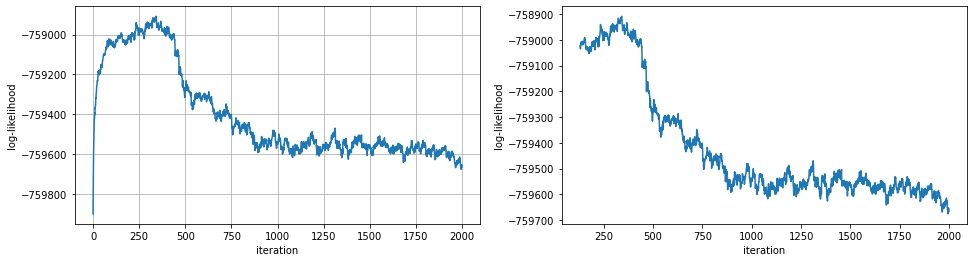

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 2 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.13715361 -0.02848152 -0.07359361 -0.02176116 -0.00446367 -0.03790161  0.11471199 -0.01372869 -0.02235603]
[ 0.12052086 -0.01963717 -0.07066768  0.01142066  0.00769546 -0.0387939  -0.27403941  0.01489421 -0.02071325]
[ 0.20198227 -0.00307256 -0.07791923  0.24393769  0.05183609 -0.07197683  0.33643938  0.01096335 -0.05861595]
[ 0.16560435  0.01039201 -0.072656    0.14782422  0.02332331 -0.04493922  0.34883049  0.01329116 -0.04570231]
[-0.05645772  0.00149556 -0.07666774  0.71183822  0.03586783 -0.06257902  0.35005993  0.01541439 -0.0696511 ]



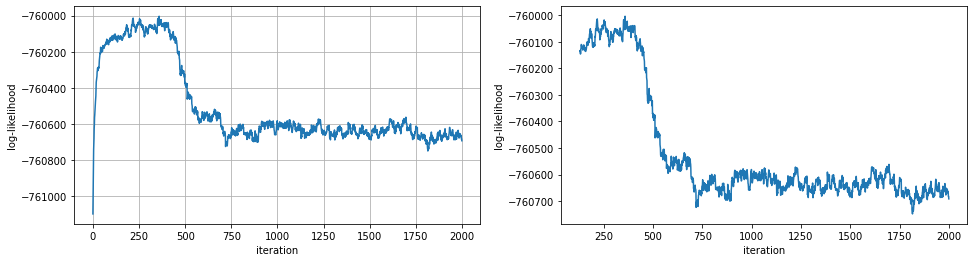

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 3 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  


[ 0.18935862 -0.00482311 -0.07324037  0.16495068 -0.0146762  -0.05166794 -0.00767808  0.00560464 -0.04819889]
[ 0.14487315  0.02789391 -0.07545149  0.07491906  0.04032492 -0.05385713  0.14713934 -0.00702568 -0.0603061 ]
[ 0.0878804   0.01004309 -0.0830329  -0.07080011  0.00239237 -0.03934592  0.02662131 -0.00416423 -0.03594389]
[ 0.02337267  0.01902153 -0.00542545  0.44918169  0.02768261 -0.05128884  0.32360092  0.00594633 -0.09421337]
[ 0.12512423 -0.03013634 -0.07156842 -0.09186181 -0.00273167  0.00200955 -0.05944167 -0.0032247   0.0032795 ]



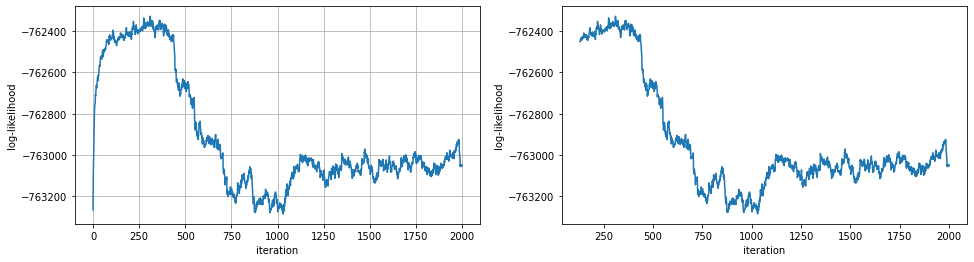

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 29.0 0.8055555555555556
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 4 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.3106816  -0.0026581  -0.07311358 -0.35039458  0.00675381 -0.04194936 -0.33653848 -0.01250862 -0.01439476]



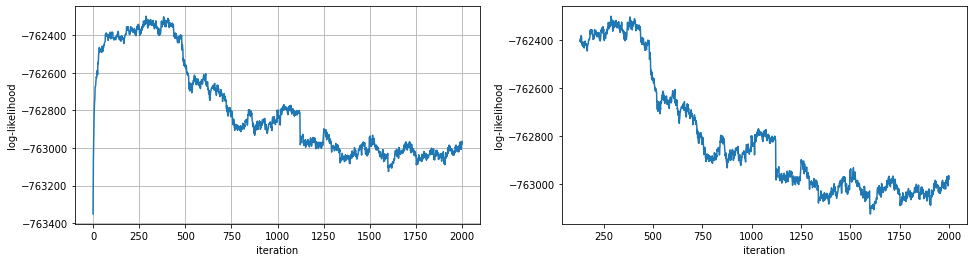

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 5 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.0734652  -0.00376275 -0.07179822 -0.09779491  0.01968537 -0.05001398 -0.16246824 -0.00215276 -0.04396663]
[ 0.20849996  0.01018063 -0.06943339  0.15583784  0.0039358  -0.04684559 -0.46394579 -0.00254544 -0.03595891]



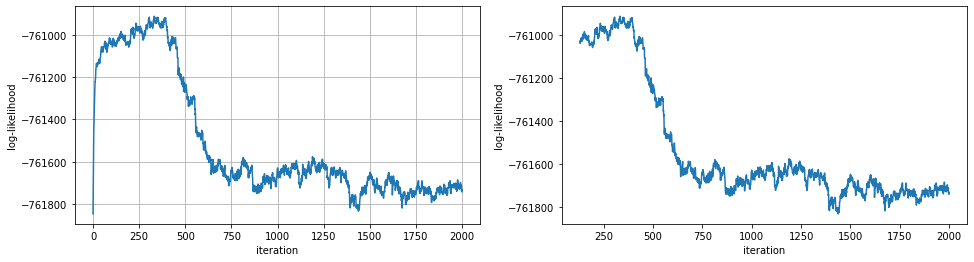

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 31.0 0.8611111111111112
[[0. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 6 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


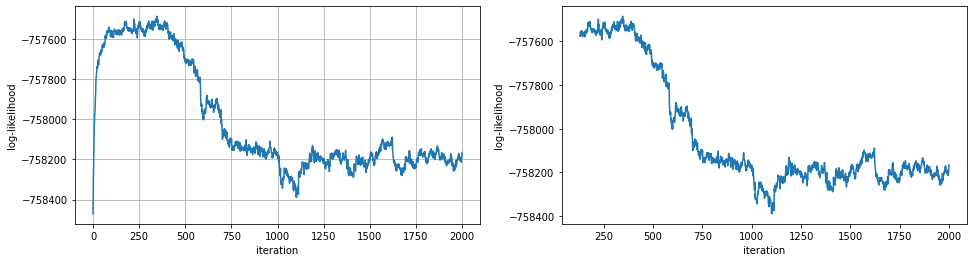

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 7 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


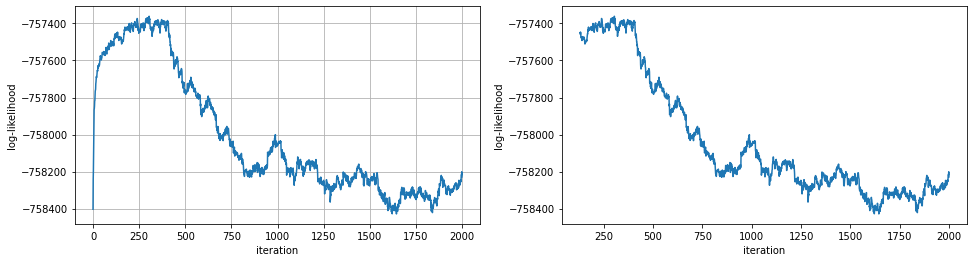

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 8 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.26701976  0.00185233 -0.03517506  0.79218347  0.00332902 -0.06612502  0.65195739  0.01466474 -0.08050342]
[ 0.2310937   0.00585941 -0.06868314  0.53104141  0.00174385 -0.07294529  0.31314378 -0.0013078  -0.07607372]
[-0.04744162  0.01337776 -0.03504142  0.01150406  0.00336062 -0.06690541  0.1712832   0.02207487 -0.08964452]



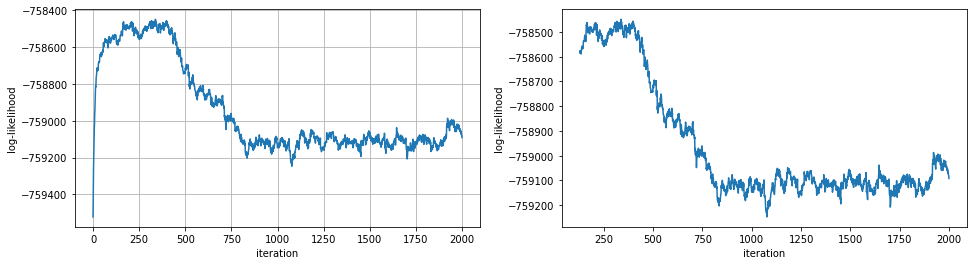

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 23.0 0.6388888888888888
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 9 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.20768712 -0.00640145 -0.0827338  -0.15688963  0.02252389 -0.03790137 -0.04167839  0.00654768 -0.03325093]
[ 0.17736504  0.0025115  -0.07160708  0.54425487  0.00247854 -0.0648982   0.15866522  0.00873713 -0.05572783]
[ 0.14504046  0.01101185 -0.04821289  0.58509698  0.01710793 -0.07340398  0.51121326  0.00543863 -0.08068312]



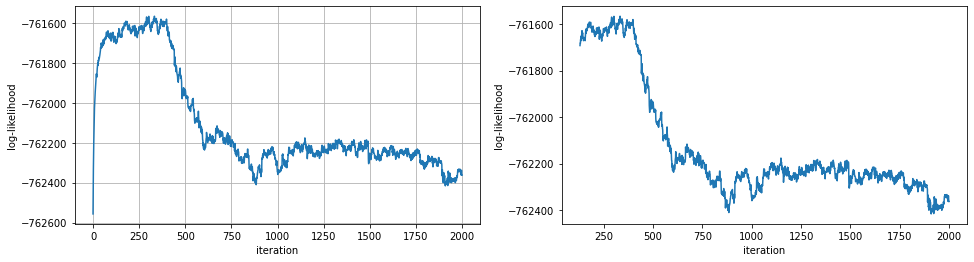

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 30.0 0.8333333333333334
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 10 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 34 22]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.19043378  0.01319993 -0.05162074  0.15496327  0.02026995 -0.06209669 -0.06450738 -0.00412535 -0.07968238]
[ 0.09145144  0.0087589  -0.07605133  0.05993831  0.01833977 -0.06688588 -0.20780554 -0.02042543 -0.063485  ]
[ 0.20029281  0.00707446 -0.08113003 -0.06033267  0.04077239 -0.04814893 -0.02791542 -0.00947502 -0.03250846]
[-0.15263106  0.00849027 -0.07081788 -0.68941785 -0.01651753 -0.0200356  -0.63987713 -0.0170191  -0.01565202]



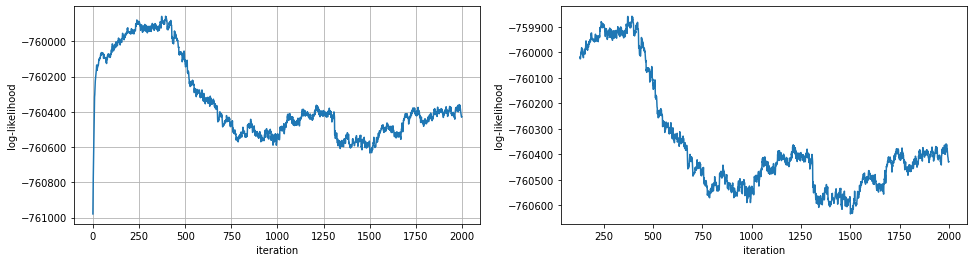

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 36.0 1.0
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 11 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.10348159 -0.0190336  -0.08533937  0.21757995  0.00208345 -0.05283545 -0.0952119  -0.02017672 -0.03245853]



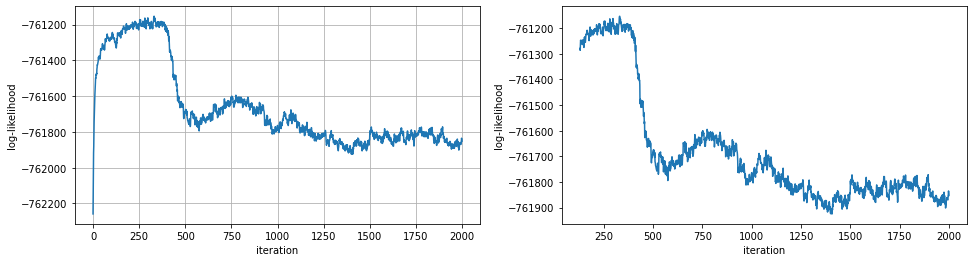

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 30.0 0.8333333333333334
CI traps fix total, ratio: 28.0 0.7777777777777778
[[0. 1. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 12 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[40 30 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.13951914  0.00437087 -0.08479697 -0.17677224  0.01623532 -0.03128579 -0.41960241 -0.00414754  0.00648632]
[ 0.01146813 -0.00138806 -0.07186252  0.22020713 -0.01129984 -0.02747592 -0.14176723 -0.0027761  -0.03973321]



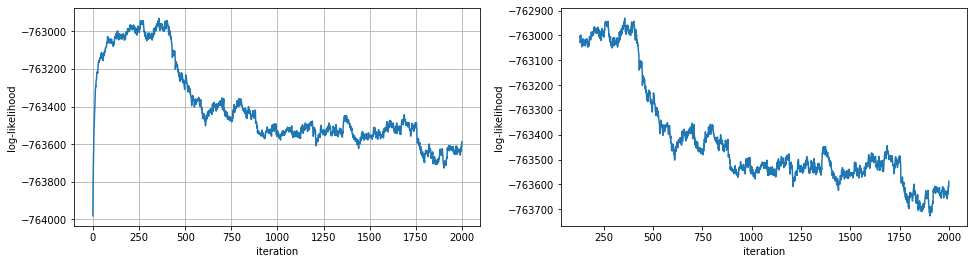

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 31.0 0.8611111111111112
[[0. 1. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 13 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.05999773 -0.01527054 -0.07219152  0.65712969  0.01061575 -0.06257959  0.35988841 -0.00332625 -0.05419722]



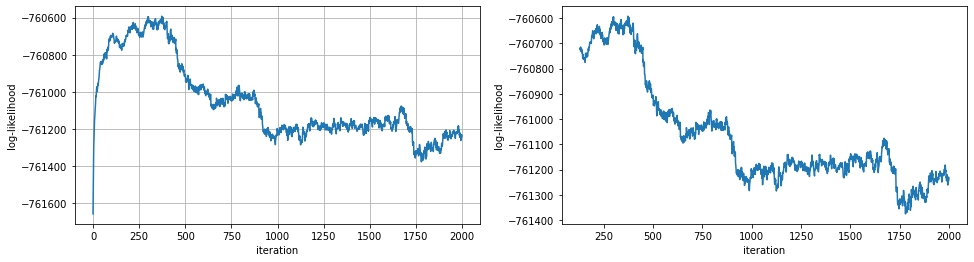

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 14 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  


[ 0.42454772  0.01074295 -0.06888739  0.58558555  0.05036207 -0.08683626  0.32434646 -0.00277448 -0.08704211]
[ 0.12810063  0.00988366 -0.03494201  0.12151258  0.01882577 -0.04423683 -0.04051617 -0.00037207 -0.08544253]
[ 0.18725186  0.00311649 -0.06410347  0.28522055  0.00581281 -0.04226763  0.01429951 -0.00229089 -0.0889998 ]
[ 0.02095832 -0.01536085 -0.07495172  0.13968785  0.00313385 -0.06565168 -0.04079117  0.00119118 -0.02790879]
[ 0.42620553  0.02556589 -0.01031541  0.51071419 -0.03591897 -0.06431411  0.35624519 -0.0070133  -0.08180033]
[ 0.03904407 -0.00451479 -0.05409396  0.25145222 -0.02149378 -0.06162984  0.40314576 -0.02446121 -0.07844226]



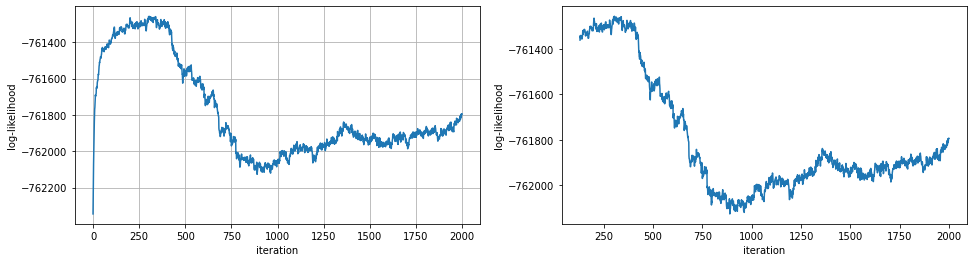

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 15 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.09338166  0.00255397 -0.07470995 -0.08661151 -0.01155955 -0.02880768 -0.44112333 -0.00427732 -0.00352813]



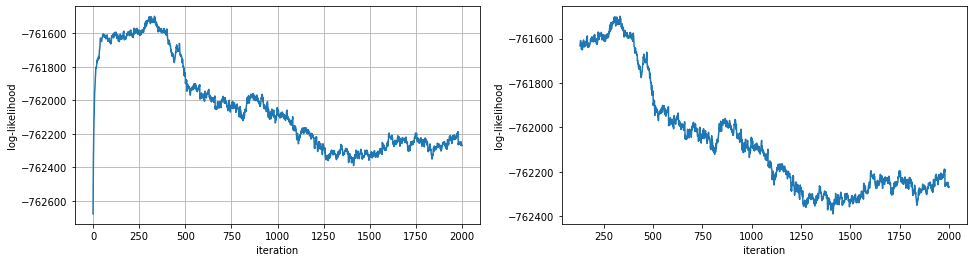

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 16 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.04461578 -0.00538956 -0.08471384  0.42707618  0.00190389 -0.03799005 -0.01793442 -0.02043607 -0.04355049]
[-0.02012511  0.00138482 -0.06667013  0.32348031  0.00749433 -0.07956736  0.14299508  0.0073233  -0.08389525]
[ 0.1402386  -0.00455017 -0.0797131   0.35217635  0.01988878 -0.08339133  0.31873853 -0.00209424 -0.07187181]



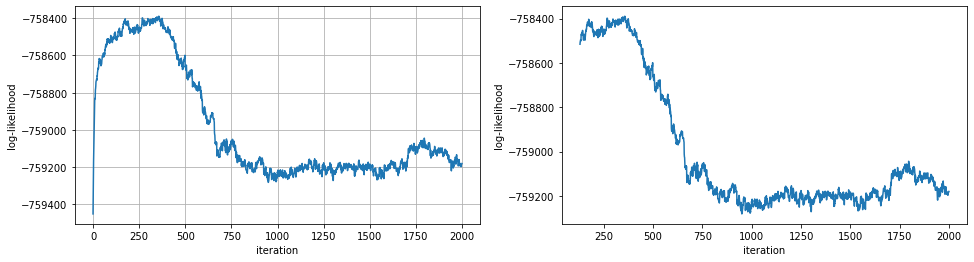

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 17 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 32 21]  


[-0.05606716  0.01778405 -0.07364329  0.48235129  0.01515236 -0.0409937   0.19955167 -0.01162145 -0.02567055]
[-0.02797357  0.00527544 -0.07570911  0.31279378 -0.01090633 -0.01982806 -0.13908387 -0.01504465 -0.00173389]
[-0.08801108 -0.00444268 -0.03777766  0.21675731  0.00911008 -0.07145053  0.21512216 -0.00794588 -0.08002225]



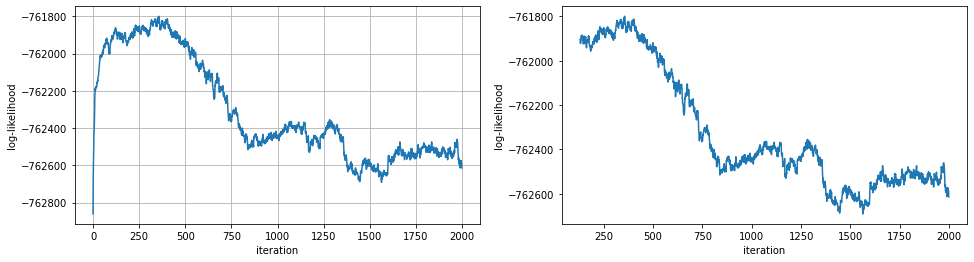

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 18 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.06147154  0.01962487 -0.07677753  0.08317735  0.01754834 -0.07360241 -0.25668541 -0.00861898 -0.06434643]
[ 0.07206911 -0.00201349 -0.07473799  0.35225523  0.01704068 -0.04163899  0.17453513 -0.00960997 -0.03888062]
[-0.09321503  0.0070907  -0.06545939  0.48043741  0.03995179 -0.0697765   0.11315862 -0.00068288 -0.08737917]
[-0.24500622 -0.01298243 -0.07582965  0.1754749   0.00862175 -0.03284067 -0.10024756 -0.01507011 -0.06046127]
[-1.27821686e-02 -3.29348728e-05 -7.53087233e-02  1.22218864e-01  3.73156875e-03 -1.80727993e-02
  1.84501909e-02 -1.31084180e-02 -4.47581157e-02]
[ 2.52616125e-01  4.79612172e-04 -2.49670336e-02  9.97752145e-01  4.80817387e-02 -7.25833656e-02
  9.82501559e-01  2.02207879e-02 -8.42475093e-02]
[ 0.1933426  -0.01329126 -0.08256496  0.54829176  0.0242715  -0.06838933  0.09983631  0.01550273 -0.07243436]
[-0.0472682  -0.02612649 -0.07501416 -0.0951661  -0.00618856 -0.06249218 -0.0969781  -0.00032876 -0.04429711]



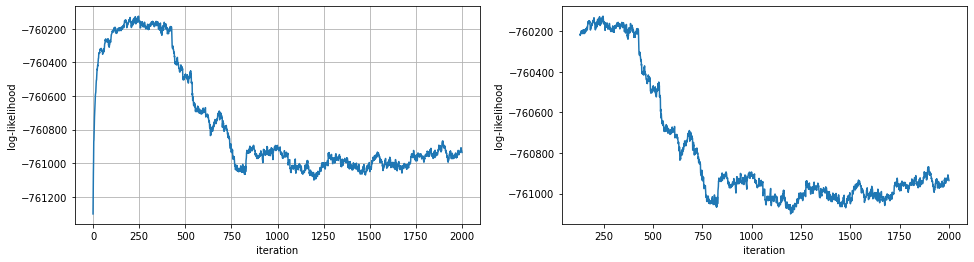

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 19 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.2109968   0.01090184 -0.04915015  0.35091683  0.05461735 -0.08207003  0.29584969  0.00399146 -0.0878218 ]
[ 0.03522451  0.02220892 -0.07663509  0.33822428  0.02578655 -0.06752991  0.25655249 -0.02472974 -0.08407989]



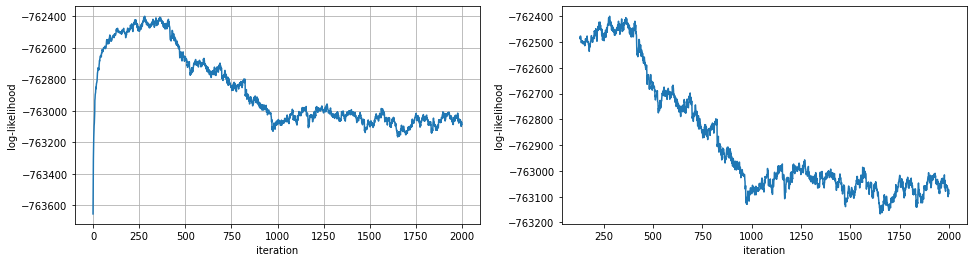

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 20 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.27753577 -0.00747116 -0.07661162 -0.23723336 -0.00226917 -0.00074182 -0.1078302  -0.01812597 -0.02904383]
[ 0.08895089  0.00250938 -0.07558234  0.2240609   0.00130905 -0.06241939 -0.24605011  0.00802549 -0.04772954]
[ 0.22736116  0.02182725 -0.07338146  0.39508878 -0.00591064 -0.05003902  0.14393548  0.01047012 -0.04716445]
[ 0.12820571  0.01976059 -0.06706434  0.6436209   0.05006875 -0.08193452  0.64642344  0.00238406 -0.09232917]



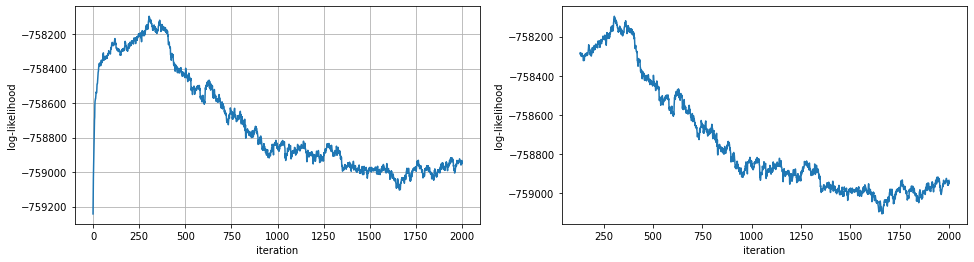

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 30.0 0.8333333333333334
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 21 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[34 24 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.00350799 -0.00859304 -0.07167413 -0.05267626 -0.02100358 -0.0126766  -0.10771163  0.01119221 -0.01019664]
[-0.03216507 -0.00658815 -0.07795     0.24198191  0.01443432 -0.04998742  0.36329429 -0.00104331 -0.05255924]
[-0.18224315 -0.00894604 -0.08119785  0.14626493  0.00281116 -0.02979246 -0.18354057 -0.00285026 -0.01102758]



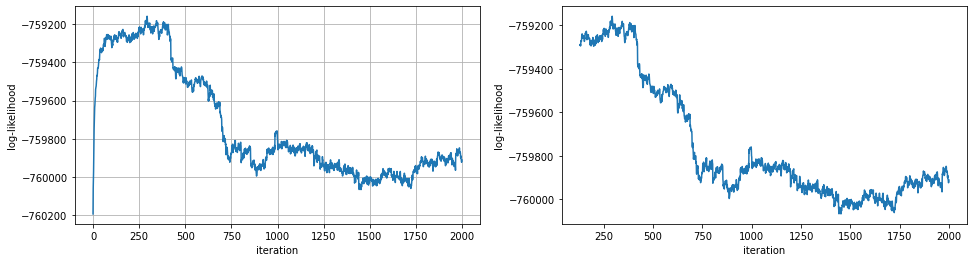

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 22 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.03582739  0.01229963 -0.07405652  0.39922749  0.02862359 -0.05730991  0.08278948  0.00271352 -0.05931525]
[ 0.60353938  0.03213933 -0.06934613  0.84852821  0.04626023 -0.08255935  0.56578345  0.01108419 -0.08091135]
[-0.02265231 -0.00817834 -0.07301975  0.06700019  0.01758065 -0.02909749 -0.15375156 -0.0031223  -0.00640595]



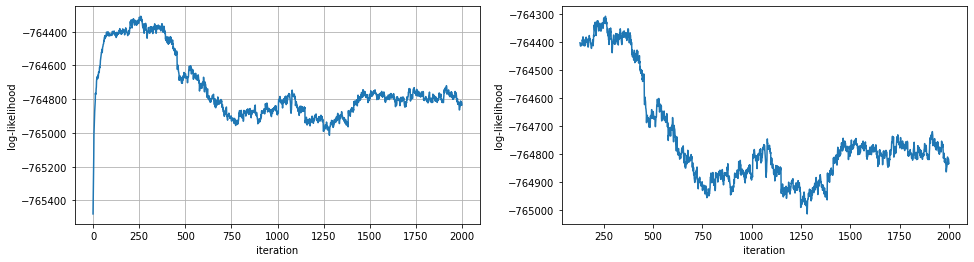

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 32.0 0.8888888888888888
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 23 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.18777014 -0.00393631 -0.07032104 -0.33600956 -0.01703138 -0.01304479 -0.5208088  -0.00578919 -0.02990664]
[ 0.43627174  0.02783144 -0.03423952  0.29412615  0.05735502 -0.05857296  0.40560199  0.00498876 -0.07943123]
[ 0.20374434 -0.00168923 -0.07928169  0.16171319  0.00393293 -0.07833347 -0.00438423 -0.0079333  -0.06921983]
[ 0.05171631 -0.00142367 -0.08151458 -0.1104632  -0.00342681 -0.05045774 -0.11834086 -0.01580625 -0.05557988]
[ 0.20339265  0.00818283 -0.07686685  0.47166329  0.00129665 -0.06386901  0.16927106 -0.00790354 -0.06296646]



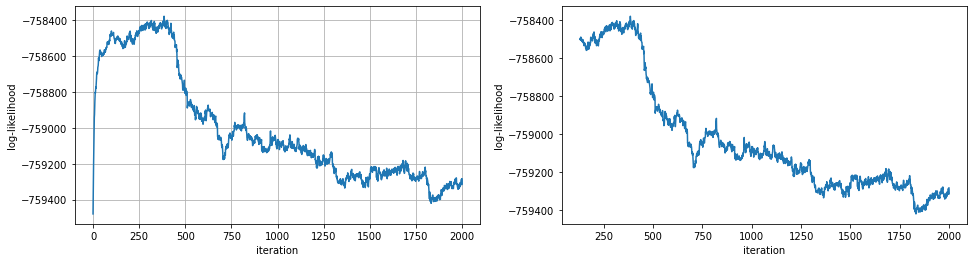

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 29.0 0.8055555555555556
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 24 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.20348696 -0.0055079  -0.07087777 -0.03788974 -0.00258849 -0.03337188 -0.11748458 -0.00395015 -0.02358428]
[ 0.32794071  0.01120401 -0.08087191  0.40170122  0.04470709 -0.04443677  0.24706514  0.00529725 -0.05052926]
[ 0.18286022 -0.01208408 -0.08080259  0.32346466  0.04620035 -0.08001053  0.41200254  0.00837313 -0.04731068]
[ 0.17679479 -0.0217195  -0.07413608  0.44457176  0.01517328 -0.07109971  0.24546786 -0.02059571 -0.07936003]
[ 0.11344245  0.02336    -0.03283931  0.14887184  0.00383716 -0.07169512 -0.08856578  0.01343532 -0.08642149]



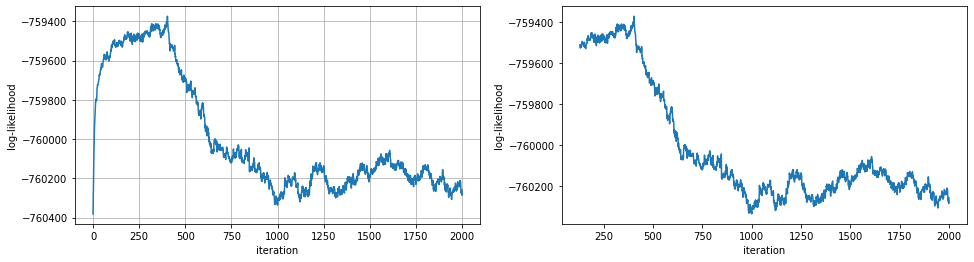

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 25 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.20822404  0.01082746 -0.07167944 -0.34809073 -0.01319025 -0.02212746 -0.08793145 -0.01384814 -0.03169232]
[-0.24324483 -0.01788015 -0.08589946 -0.11903774  0.01145454 -0.0613119  -0.15329427 -0.00766392 -0.06563138]
[ 0.10781865  0.01134941 -0.05212182  0.53003222  0.02716501 -0.08385945  0.44936193  0.00598413 -0.08478144]
[ 0.02910681  0.01134793 -0.07394889  0.34988884  0.01311844 -0.07649453  0.08809598  0.00124677 -0.06378252]
[ 0.05083787  0.01248499 -0.01865297  0.44649135  0.00693829 -0.03417233  0.32974519  0.02245326 -0.08748381]
[ 0.33949079 -0.00458611 -0.07717868  0.02238727  0.01381142 -0.06462566  0.08767782 -0.00379072 -0.07812883]
[ 0.5603978   0.01878959 -0.01226578  0.83743474  0.06403384 -0.07308469  0.78836222 -0.00473478 -0.08941004]



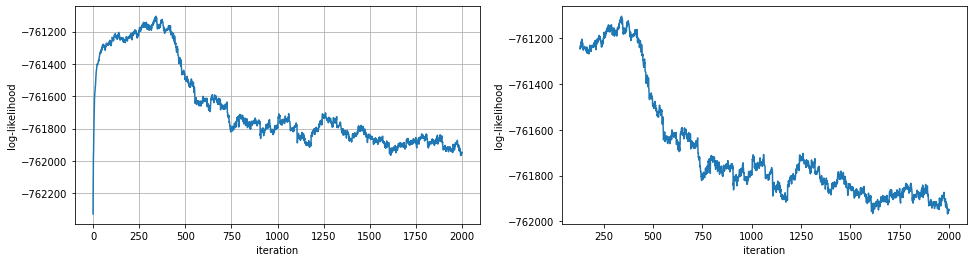

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 26 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.04583531 -0.00227745 -0.07455944 -0.50913591 -0.00808946 -0.02547733 -0.41691135  0.00158075 -0.01277041]
[ 0.27178963  0.0043428  -0.07152618  0.52841938  0.0065222  -0.07056232  0.18868077  0.01164881 -0.07373217]
[ 0.30743691  0.01114436 -0.03023118  0.80232094  0.04465169 -0.06514782  0.51667049  0.02074803 -0.08145108]
[-1.20058274e-01  4.76532863e-04 -8.27877295e-02 -7.02049419e-01 -2.57812971e-02 -3.67601965e-02
 -3.28590678e-01 -1.09011126e-02 -2.22927264e-02]
[ 0.0756231   0.02410706 -0.06718627  0.11620066  0.01793181 -0.07799091  0.25098819 -0.00366247 -0.07671503]
[ 0.13807492 -0.00627405 -0.0602673   0.67628168  0.02527101 -0.08187974  0.28923789  0.00470463 -0.07329815]



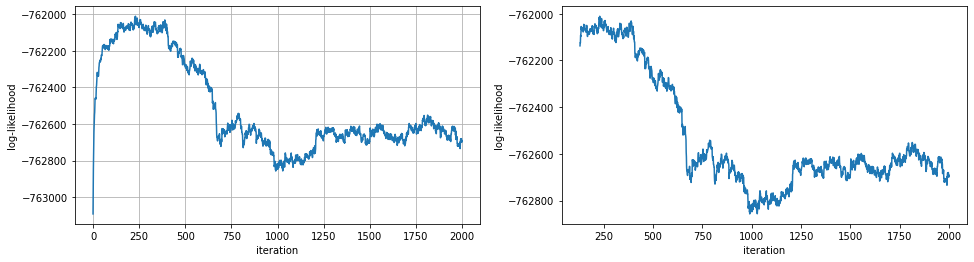

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 29.0 0.8055555555555556
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 27 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.57016309  0.01033144  0.0183163   0.95094628  0.01246516 -0.0726143   0.7521809   0.01323529 -0.08436576]
[ 0.26318172  0.00163498 -0.03720791  0.41687489  0.00206398 -0.06559855  0.15559226  0.01160937 -0.08386343]
[ 0.29810369  0.00812729 -0.04367895  0.22532229  0.03564436 -0.0779753   0.27173464 -0.00720407 -0.08071099]
[-0.37099428 -0.00332169 -0.08352503 -0.23671848 -0.02566208 -0.04768757 -0.20776434 -0.01593885 -0.06373435]



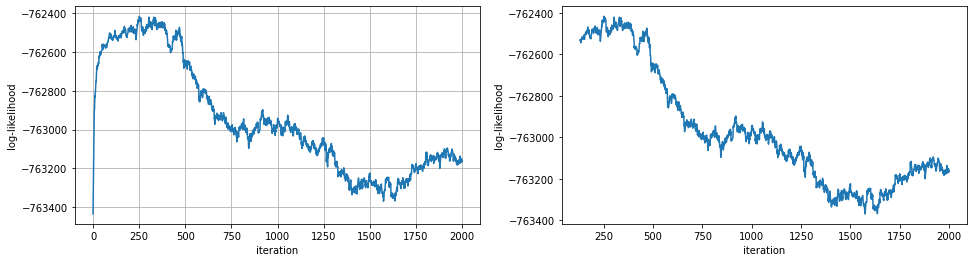

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 30.0 0.8333333333333334
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 28 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.09428765  0.01394101 -0.06820557 -0.27657131 -0.00698411 -0.0540871  -0.24601812  0.00148824 -0.081565  ]
[-0.01627442  0.02001358 -0.0426726   0.28752047  0.02507538 -0.06948096 -0.15573136 -0.00573634 -0.08519128]
[-0.09165549 -0.01422569 -0.07758374 -0.09678991 -0.00406567 -0.01993774 -0.33685631 -0.00373354  0.00707489]



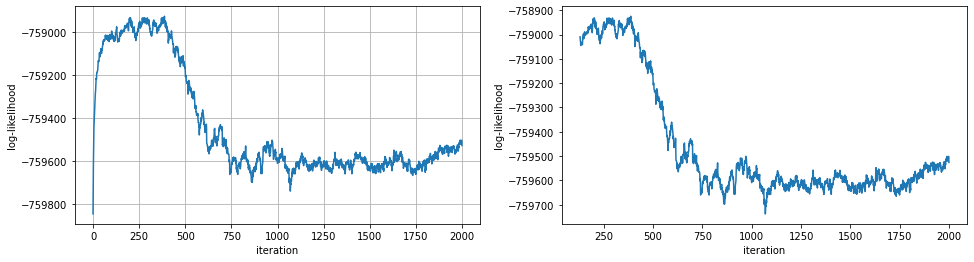

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 29 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.39122832  0.01505446 -0.02503987  0.5250066   0.02959401 -0.07573928  0.34106434  0.00345857 -0.08530264]



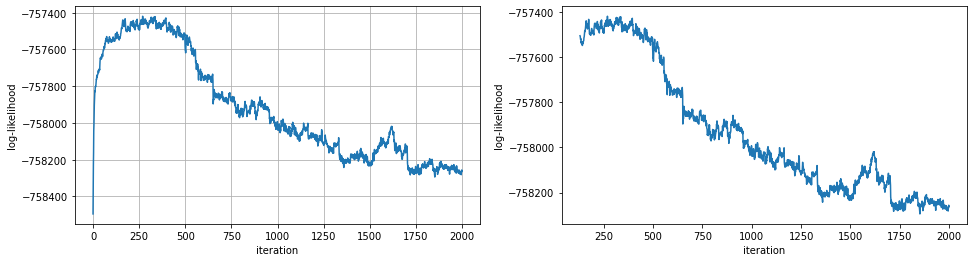

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 26.0 0.7222222222222222
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 30 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[32 26 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.09732841  0.00136656 -0.03156887  0.20219695  0.06941594 -0.07104979  0.51022036  0.01768754 -0.07623687]
[-0.31392943 -0.003002   -0.07430029 -0.25010197 -0.00315921 -0.00331578 -0.23104448 -0.00941834  0.00529983]
[-0.09390422 -0.00263826 -0.07145757  0.34434439  0.01074997 -0.06254855  0.12339783 -0.01212741 -0.05875047]
[ 0.16565003  0.00450346 -0.07223214  0.4461731   0.03170319 -0.07431243  0.3265101  -0.00109232 -0.0749564 ]



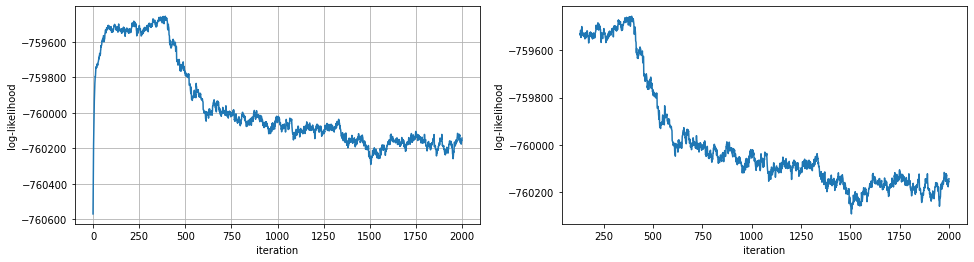

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 31 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[40 30 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


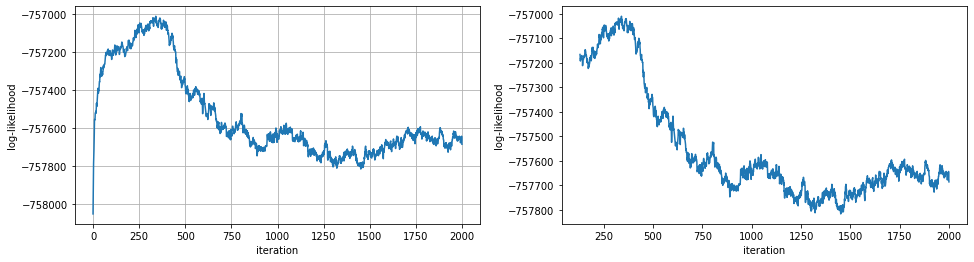

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 30.0 0.8333333333333334
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 32 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.17318394  0.01907135 -0.07073994  0.39908846  0.02628611 -0.06841797  0.12740169  0.00645377 -0.06067898]
[ 0.00758042  0.00534425 -0.07547039  0.61229164  0.02597603 -0.03824692  0.30649193 -0.0093558  -0.08206765]
[-0.00811533 -0.02309809 -0.08173566  0.29785779 -0.00274978 -0.04233818  0.05998403 -0.0129263  -0.03917997]
[-4.29219208e-02  5.62553939e-03 -7.25755522e-02 -7.72219789e-03 -1.20118409e-02 -3.42218205e-02
 -1.19392338e-01 -9.91680264e-05 -1.17191904e-02]
[-0.3255324   0.00613661 -0.08222019 -0.01231438 -0.0171056  -0.05369258 -0.01449098  0.0078786  -0.04596329]
[ 2.82550791e-04 -1.67361949e-02 -7.85264456e-02  2.08903982e-01  1.57207803e-02 -5.76654604e-02
  2.86444863e-01 -2.45982166e-02 -4.79326547e-02]
[ 0.17555141 -0.00691671 -0.08558319  0.64851761  0.01810838 -0.0621667   0.37442217  0.01633504 -0.07286588]
[ 0.37929677 -0.00748117 -0.07218643  0.36400938  0.06207874 -0.05716089  0.2646512  -0.01125999 -0.04345995]



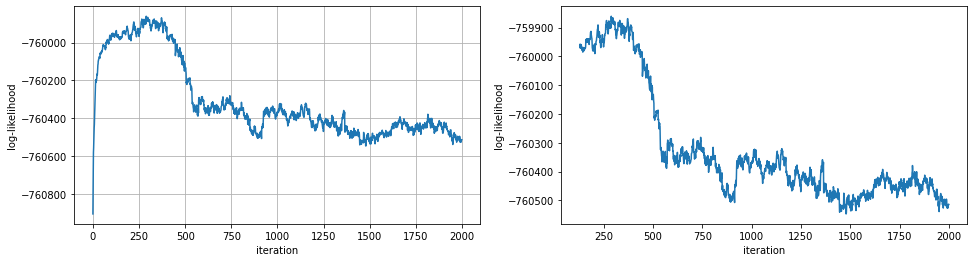

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 33 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.04101147 -0.00563821 -0.06801578  0.55578376 -0.00611049 -0.02772399  0.15361761 -0.01234256 -0.03788292]
[ 0.34840445  0.00258603 -0.07358046  0.14498383 -0.02342928 -0.0658798   0.03956988  0.00242184 -0.06970641]
[-0.41507831 -0.02205149 -0.07414598 -0.49811097 -0.0532914  -0.02621833 -0.70554491 -0.01136571 -0.00807832]
[-0.185899   -0.01231901 -0.07850956 -0.44798543 -0.01159625 -0.03583002 -0.4306051  -0.01143542 -0.03342305]
[ 0.01215298  0.01271589 -0.05816204  0.35977954  0.00886467 -0.06699335  0.08155012 -0.00567016 -0.08510211]



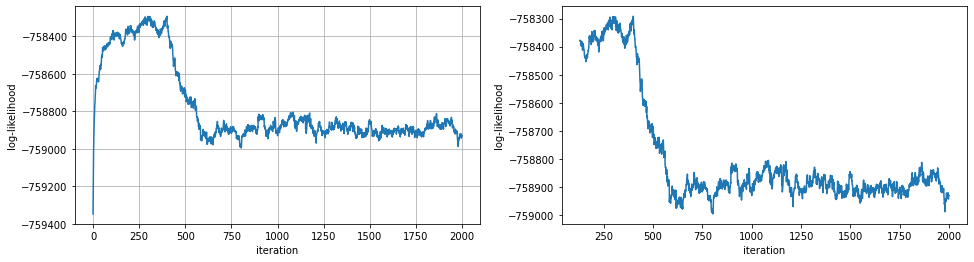

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 34 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.14827853 -0.00145103 -0.0696484  -0.03559797 -0.0249808  -0.04434726 -0.19696656 -0.01220385 -0.03263823]
[-0.18619634  0.00660461 -0.07733331  0.06237969  0.02107607 -0.0149484  -0.04562966  0.01614941 -0.03712483]
[ 0.12047719  0.00219313 -0.0768097   0.1060858   0.00655832 -0.0304282   0.09150674  0.00382995 -0.04617015]
[-0.1107461   0.0058031  -0.07123507  0.20897649  0.02596116 -0.05047964 -0.12441174 -0.01672443 -0.02799874]



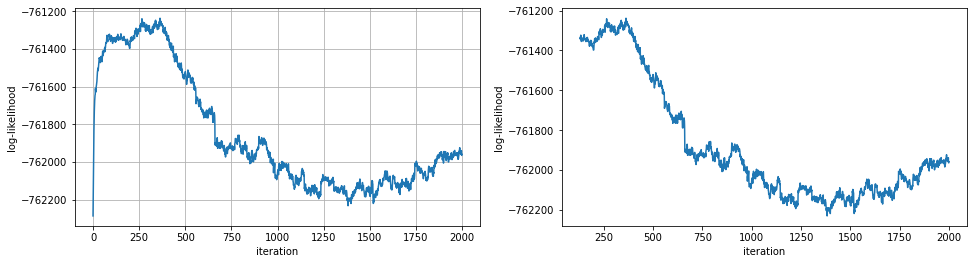

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 35 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.24122299  0.00691369 -0.0711868   0.58047558  0.0508703  -0.05351188  0.5307554   0.005963   -0.07908689]



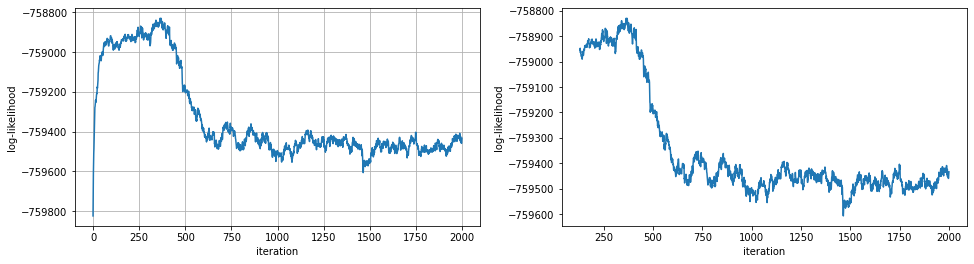

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 24.0 0.6666666666666666
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 36 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[40 30 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.31964686  0.01848323 -0.04706123  0.52896084  0.02723755 -0.06984647  0.62137353  0.02539795 -0.0844709 ]
[ 0.35446733 -0.00957843 -0.08454974  0.54492604  0.01605211 -0.06891334 -0.27622052 -0.00419001 -0.05655723]



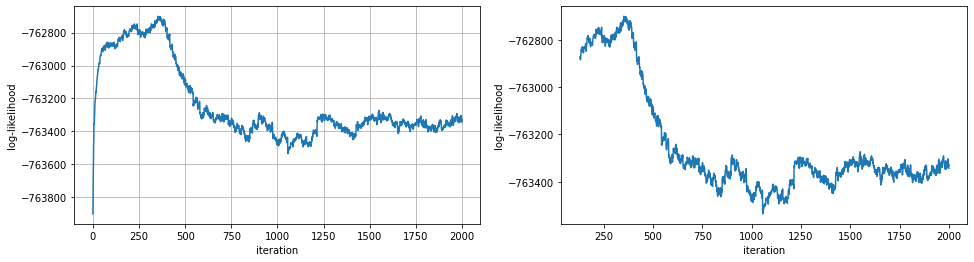

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 37 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.14872267  0.00213932 -0.07044117  0.24458151  0.01803092 -0.03772844  0.0303973  -0.00580765 -0.03512429]
[-0.2604658  -0.0096031  -0.07098438  0.27740468  0.02507953 -0.01248509  0.19028743 -0.00039509 -0.03966116]
[ 0.34100454  0.01268201 -0.05073634  0.88807701  0.03348828 -0.04705298  0.43583991  0.02738566 -0.08307222]
[-0.20063939 -0.02743457 -0.07238867  0.02800876  0.01478063 -0.037691   -0.03149456 -0.0015867  -0.02144716]



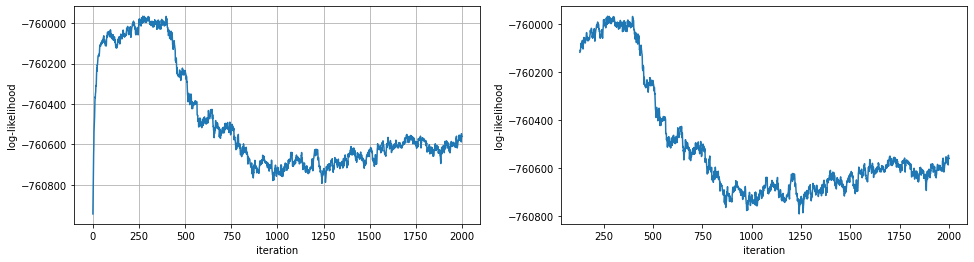

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 38 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[38 29 22]  


[ 0.0962506   0.01096315 -0.05000621  0.29583899  0.00879299 -0.08183845  0.19240239  0.01077968 -0.08677144]
[ 5.13125909e-01  1.96022350e-02 -7.31003451e-03  9.69439511e-01  2.50733679e-02 -7.43210399e-02
  9.22060424e-01 -7.15563984e-04 -8.80244987e-02]



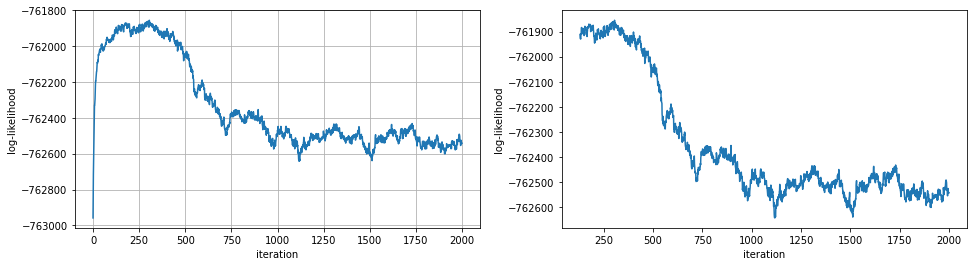

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 39 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[33 25 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.19505124  0.00395824 -0.069743    0.648237    0.02468482 -0.04536087  0.10100404  0.00822761 -0.04444622]
[-0.38261499  0.01230897 -0.060352    0.18217928  0.02127357 -0.05681544  0.11939315 -0.01078109 -0.07621017]
[ 0.02703383 -0.00061718 -0.06726964  0.37365639  0.01453617 -0.08505243  0.34686422  0.00066417 -0.05642971]
[-0.20574402  0.02107948 -0.03734554  0.28207831 -0.01385879 -0.08709808  0.10865271  0.00188794 -0.07857647]



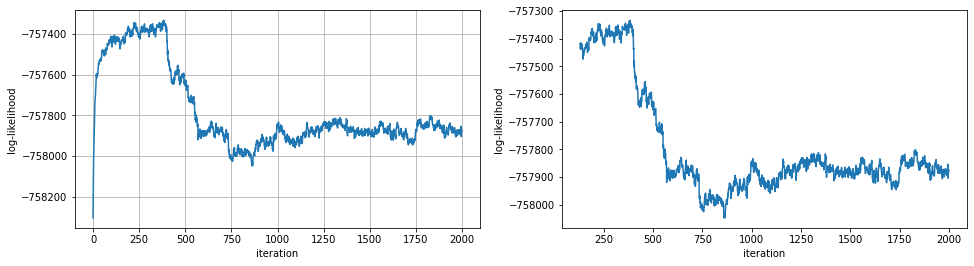

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 30.0 0.8333333333333334
CI traps fix total, ratio: 36.0 1.0
[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 40 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.20718602  0.00752099 -0.06771446  0.39656177  0.00965294 -0.08272806  0.25629501 -0.00256802 -0.04833007]



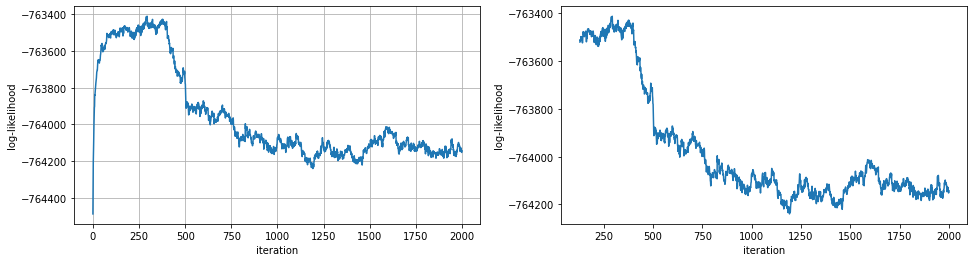

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 30.0 0.8333333333333334
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 41 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[38 29 22]  


[ 0.183696    0.00877623 -0.05654369  0.58892579  0.0171711  -0.08480701  0.69727944  0.00212731 -0.06145661]
[ 0.20361688  0.02243238 -0.02130739  0.74459008  0.02877011 -0.0492229   0.62033313 -0.00727026 -0.08384942]
[ 0.01032365  0.00193774 -0.07131366 -0.31251007 -0.00690197 -0.0092437  -0.46090728 -0.00833338 -0.00561956]
[ 0.09487609  0.02834643 -0.05570386  0.55510507  0.02264318 -0.04794511  0.42427034 -0.00166115 -0.08301101]
[-0.06538969  0.00533269 -0.07259813 -0.03187288  0.00390042 -0.03752333 -0.2292795  -0.00819903 -0.04501135]
[ 0.02750763 -0.00727691 -0.02399044  0.65400468  0.03449475 -0.05112304  0.70677473  0.00642551 -0.08506993]



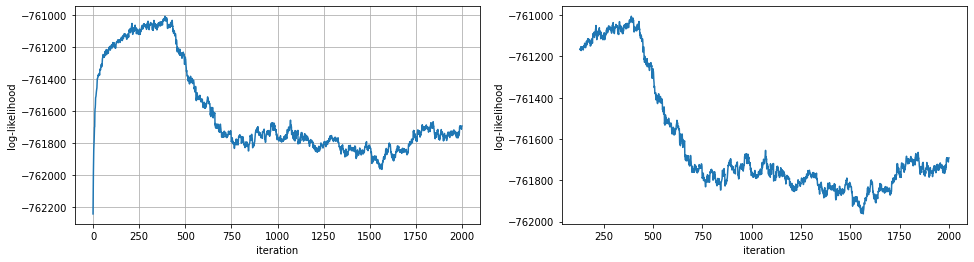

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 42 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.1046982   0.01448069 -0.03175197  0.38327891 -0.00792272 -0.06574672  0.21554321  0.0026655  -0.08043048]
[ 0.45151471  0.00167982 -0.08183444  0.72289573  0.02134931 -0.0668167   0.3862474  -0.00344186 -0.06211126]
[-0.25903133 -0.01420277 -0.0694879  -0.24710636 -0.00775824 -0.00766834 -0.12073923 -0.00577984  0.00799877]
[ 5.74248400e-02 -1.30948525e-03 -7.25760995e-02  7.34018906e-02 -2.48248504e-04 -3.89749859e-02
 -3.95497525e-01  2.88207996e-03 -3.03949641e-02]
[-0.3084176   0.01190146 -0.07181955 -0.23106088 -0.00306452 -0.05106325 -0.31411552 -0.01358677 -0.01758556]
[ 0.08605494 -0.01286194 -0.07170919  0.5946836   0.02330529 -0.04730172  0.23107529 -0.00490939 -0.03409737]
[ 0.01943159 -0.00380711 -0.07423604  0.16594904  0.03379976 -0.05231426  0.26572355 -0.01017272 -0.02532845]



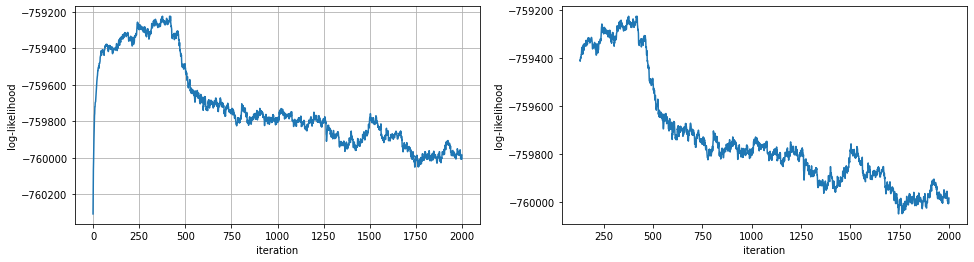

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 35.0 0.9722222222222222
CI traps fix total, ratio: 32.0 0.8888888888888888
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 43 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[38 29 22]  


[-0.09735268  0.00249183 -0.07352742  0.06647017  0.00144728 -0.04522854 -0.01644809 -0.01505872 -0.04178586]
[ 0.07457883  0.0074791  -0.07494036  0.38059503  0.00677759 -0.06701812  0.29016094 -0.00224404 -0.0519761 ]
[-0.01343604 -0.01186039 -0.07899037  0.23923288 -0.01917714 -0.06712956 -0.27647348  0.00407595 -0.02975541]
[ 0.17636807  0.00559287 -0.04494069  0.91806347  0.03552751 -0.06917496  0.82139925  0.00326258 -0.08314781]



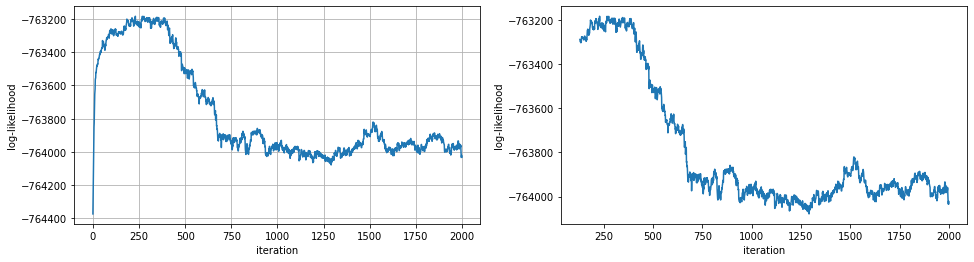

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 44 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.26670041 -0.01206059 -0.07172876  0.3030008   0.02055479 -0.0514548   0.2573337   0.00076923 -0.06414161]
[ 4.61753964e-01 -4.84954507e-04 -5.21428982e-02  1.07783740e+00  2.70308579e-02 -8.07276474e-02
  3.27767229e-01 -2.10465701e-02 -8.39264786e-02]
[-0.22335851 -0.01586118 -0.07619103 -0.23269867 -0.00758775 -0.0323877  -0.31600841 -0.01250686 -0.02411009]
[ 0.31147898 -0.00215388 -0.0699073   0.58630062  0.01846746 -0.07518319  0.26901168 -0.01696321 -0.07956521]



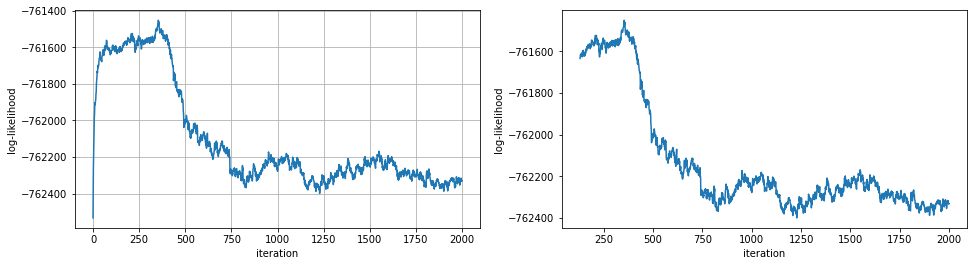

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 31.0 0.8611111111111112
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 45 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.05806022  0.00512076 -0.07130577  0.17080919 -0.02158868 -0.0523975  -0.15404289 -0.01034115 -0.00587076]
[ 0.13268898 -0.00560374 -0.07819173  0.20213329 -0.00877171 -0.05312765 -0.00673137  0.00641454 -0.03827028]



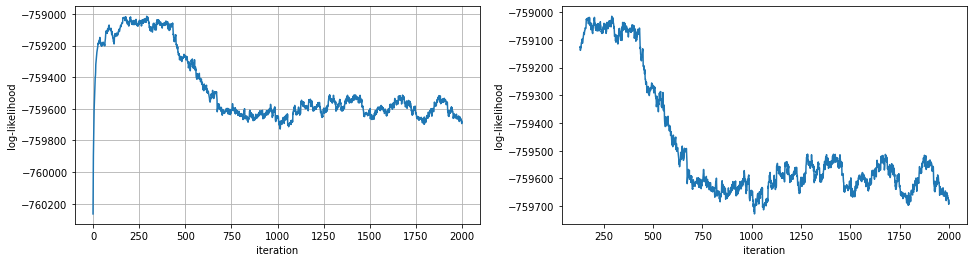

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 28.0 0.7777777777777778
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 46 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[32 26 20]  probeE g:[2 1 0] counts:[38 29 22]  


[ 0.35106977  0.0188013  -0.0652287   0.99567394  0.02075193 -0.06156365  0.9855406   0.02739762 -0.08270321]
[ 0.4381234  -0.0351608  -0.07459909  0.84022319  0.02361861 -0.05442706  0.47060452 -0.00978297 -0.04631238]
[-0.15827999  0.01704326 -0.07142114 -0.39709997  0.01176134 -0.07671587 -0.31007985  0.00636952 -0.07243332]



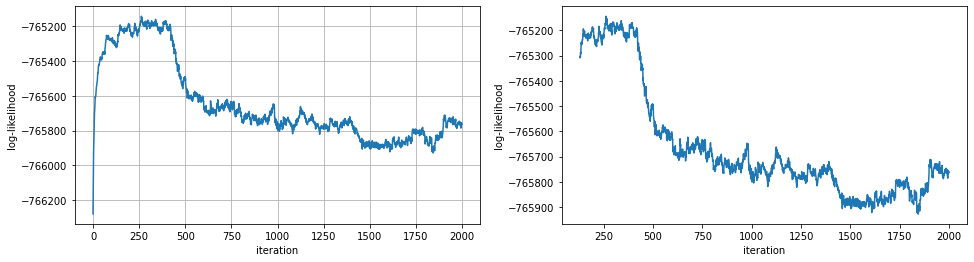

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 36.0 1.0
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 47 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.03102398  0.00183456 -0.07539329  0.09331597  0.00949148 -0.0475394  -0.31353458 -0.00297032 -0.03245477]
[ 0.17827894  0.01313336 -0.07342798  0.47144331  0.0552188  -0.07802828  0.45236874  0.00902576 -0.07118438]



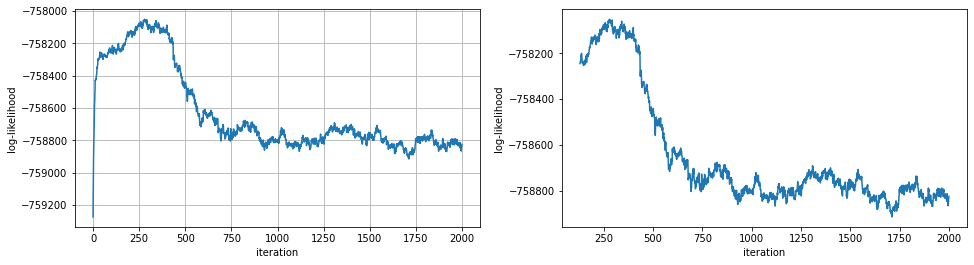

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 34.0 0.9444444444444444
CI traps fix total, ratio: 34.0 0.9444444444444444
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 48 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.34258317  0.0066796  -0.00402471  0.75871373  0.01919715 -0.06836973  0.34422895 -0.01344095 -0.07764585]
[-0.07413787  0.00548594 -0.07721932 -0.10056573 -0.00809483 -0.055792   -0.07743213  0.00789391 -0.0581273 ]
[-0.11129645 -0.00678534 -0.07602894 -0.4634425  -0.00753435 -0.07521449 -0.54039967 -0.02131638 -0.07127789]



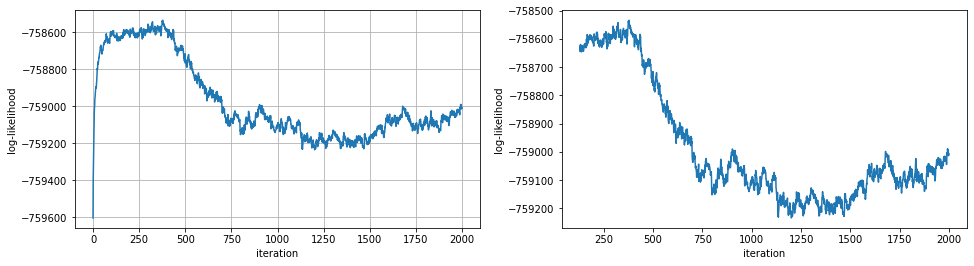

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 28.0 0.7777777777777778
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 49 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.00234932 -0.00089214 -0.08427557  0.47400832  0.01164363 -0.06978498  0.37337739 -0.00090489 -0.06064701]
[-0.1135729   0.00021859 -0.08450236 -0.1071341   0.02268149 -0.05235453 -0.10988364 -0.02194422 -0.04223712]
[ 0.10358699 -0.00838941 -0.04083971  0.75733887  0.02342316 -0.07613506  0.86224233  0.01594314 -0.08344227]
[ 0.25120801  0.00517473 -0.07286381  0.56743241  0.02031614 -0.08612622  0.55329068 -0.00183733 -0.08607085]
[ 0.26289564  0.0113584  -0.05052956  0.93317697  0.04216595 -0.05076039  0.554324    0.00674247 -0.07671775]
[ 1.80577964e-01  8.60407749e-03 -7.94089193e-02 -1.17971491e-01  1.08260756e-04 -6.78978859e-02
 -9.83047328e-02 -4.82120606e-03 -5.54985690e-02]
[-0.0413933   0.00148108 -0.07106128 -0.45468864  0.0162376  -0.04332199 -0.41640758  0.00107777 -0.02404485]



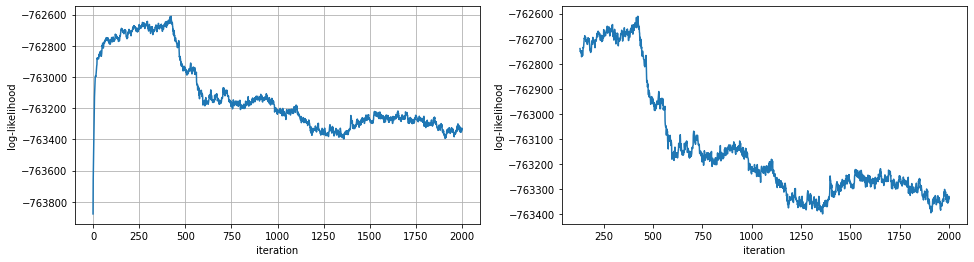

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 33.0 0.9166666666666666
CI traps fix total, ratio: 35.0 0.9722222222222222
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


In [5]:
seed_range = trange(1, 50)
for random_seed in seed_range:
    runner(random_seed)